In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_train_data(filename):
    train = pd.read_csv(filename,encoding='big5')
    
    ### seperate data 
    data = [[] for i in range(18)]
    for r,d in enumerate(train.iloc[:,3:].values):
        data[r%18].append(d)
    data = np.array(data).reshape((18,-1))
    
    return data

def load_test_data(filename):
    test = pd.read_csv(filename,encoding='big5',header = None)
    test_data = [[] for i in range(18)]
    for r,d in enumerate(test.iloc[:,2:].values):
        test_data[r%18].append(d)
    test_data = np.array(test_data).reshape((18,-1))
    
    return test_data

In [2]:
train_data = load_train_data('./data/train.csv')
test_data = load_test_data('./data/test.csv')

print(train_data.shape)
print(test_data.shape)

(18, 5760)
(18, 2160)


In [39]:
def get_train_data(data,hours):
    train_x_18 = []
    train_x_1 = []
    train_y = []

    for i in range(0,data.shape[1]-hours):
        train_x_18.append(data[:,i:i+hours].reshape((-1)))
        train_x_1.append(data[9,i:i+hours].reshape((-1)))
        train_y.append(data[9][i+hours])
        
    train_x_18 = np.array(train_x_18)
    train_x_1 = np.array(train_x_1)
    train_y = np.array(train_y).astype(np.float64)

    # replace NR to 0
    train_x_18[train_x_18 == 'NR'] = 0
    train_x_18 = train_x_18.astype(np.float64)
    train_x_1 = train_x_1.astype(np.float64)
    
    return train_x_18, train_x_1, train_y

def get_test_data(data,hours):
    test_x_18 = []
    test_x_1 = []
    
    for i in range(0,data.shape[1],hours):
        test_x_18.append(data[:,i:i+hours].reshape(-1))
        test_x_1.append(data[9,i:i+hours].reshape(-1))
        
    test_x_18 = np.array(test_x_18)
    test_x_1 = np.array(test_x_1)
    
    test_x_18[test_x_18 == 'NR'] = 0
    test_x_18 = test_x_18.astype(np.float64)
    test_x_1 = test_x_1.astype(np.float64)
    return test_x_18, test_x_1

def get_test_data_s(data,hours):
    test_x_18 = []
    test_x_1 = []
    
    for i in range(0,data.shape[1],9):
        test_x_18.append(data[:,i+hours-1:i+9].reshape(-1))
        test_x_1.append(data[9,i+hours-1:i+9].reshape(-1))
        
    test_x_18 = np.array(test_x_18)
    test_x_1 = np.array(test_x_1)
    
    test_x_18[test_x_18 == 'NR'] = 0
    test_x_18 = test_x_18.astype(np.float64)
    test_x_1 = test_x_1.astype(np.float64)
    return test_x_18, test_x_1

In [40]:
train_x_18_9, train_x_1_9, train_y_9 = get_train_data(train_data,9)
print(train_x_18_9.shape)
print(train_x_1_9.shape)
print(train_y_9.shape)

train_x_18_5, train_x_1_5, train_y_5 = get_train_data(train_data,5)
print(train_x_18_5.shape)
print(train_x_1_5.shape)
print(train_y_5.shape)

test_x_18_9, test_x_1_9 = get_test_data(test_data,9)
print(test_x_18_9.shape)
print(test_x_1_9.shape)

test_x_18_5, test_x_1_5 = get_test_data_s(test_data,5)
print(test_x_18_5.shape)
print(test_x_1_5.shape)

(5751, 162)
(5751, 9)
(5751,)
(5755, 90)
(5755, 5)
(5755,)
(240, 162)
(240, 9)
(240, 90)
(240, 5)


In [41]:
# add bias term
train_x_18_9 = np.hstack([train_x_18_9,np.ones((train_x_18_9.shape[0],1))])
train_x_1_9 = np.hstack([train_x_1_9,np.ones((train_x_1_9.shape[0],1))])
test_x_18_9 = np.hstack([test_x_18_9,np.ones((test_x_18_9.shape[0],1))])
test_x_1_9 = np.hstack([test_x_1_9,np.ones((test_x_1_9.shape[0],1))])

train_x_18_5 = np.hstack([train_x_18_5,np.ones((train_x_18_5.shape[0],1))])
train_x_1_5 = np.hstack([train_x_1_5,np.ones((train_x_1_5.shape[0],1))])
test_x_18_5 = np.hstack([test_x_18_5,np.ones((test_x_18_5.shape[0],1))])
test_x_1_5 = np.hstack([test_x_1_5,np.ones((test_x_1_5.shape[0],1))])

In [42]:
def Adagrad(train_x,train_y,lr,iterations,lamda = 0):
    w = np.zeros((train_x.shape[1]))
    cost = []
    prev_gra = 0

    for i in range(iterations):
        pre = train_x.dot(w)
        loss = pre - train_y
        gradient = 2*np.dot(train_x.T,loss)/train_x.shape[0] + lamda*w
        prev_gra += gradient**2
        ada = np.sqrt(prev_gra)
        w -= lr*gradient/ada
        cost.append((np.sum(loss**2)/train_x.shape[0]))
    return w,cost

In [43]:
def output_result(filename,predict_value):
    id_ = []
    for i in range(predict_value.shape[0]):
        temp = 'id_'+str(i)
        id_.append(temp)
    output = pd.DataFrame(columns=['id','value'])
    output['id'] = id_
    output['value'] = predict_value
    output.to_csv(filename,index = False)
    
    print(output.head())

In [44]:
# 1 feature 5 hour
opt_cost = 100
opt_w = np.ones((train_x_1_5.shape[1]))
for i in [0,0.02,0.1,1,5]:
    w,cost = Adagrad(train_x_1_5,train_y_5,i,20000)
    if(cost[-1] < opt_cost):
        opt_cost = cost[-1]
        opt_w = w
    print(cost[-1])

735.81424848
39.7102721142
39.5815709614
39.5815709614
39.5815709614


In [45]:
pre = np.dot(test_x_1_5,opt_w)
output_result('output_rp1_5.csv',pre)

     id      value
0  id_0   3.823649
1  id_1  15.379179
2  id_2  24.413549
3  id_3   6.280863
4  id_4  26.673194


In [46]:
# 18 feature 5 hour
opt_cost = 100
opt_w = np.ones((train_x_18_5.shape[1]))
for i in [0.01,0.02,0.03]:
    w,cost = Adagrad(train_x_18_5,train_y_5,i,20000)
    if(cost[-1] < opt_cost):
        opt_cost = cost[-1]
        opt_w = w
    print(cost[-1])

35.3330471747
35.1130789792
35.1115177128


In [47]:
pre = np.dot(test_x_18_5,opt_w)
output_result('output_rp18_5.csv',pre)

     id      value
0  id_0   4.029894
1  id_1  16.141520
2  id_2  23.398910
3  id_3   6.590351
4  id_4  26.251778


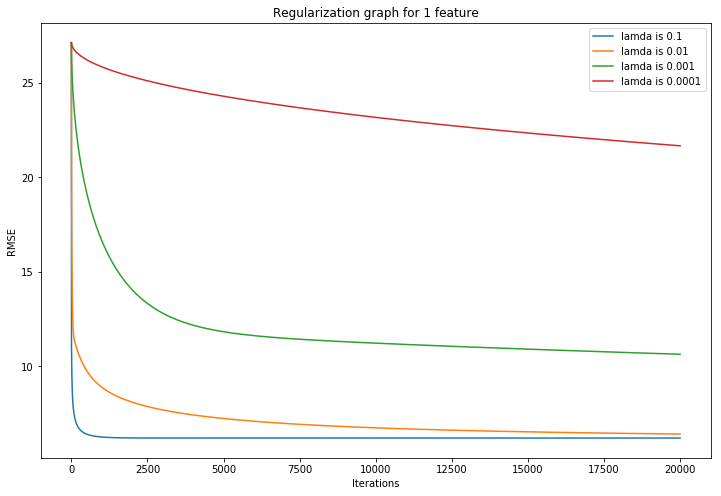

In [55]:
# 1 feature 9 hour
opt_cost = 100
opt_w = np.ones((train_x_1_9.shape[1]))
plt.figure(figsize=(12,8))
plt.title('Regularization graph for 1 feature')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
for i in [0.1,0.01,0.001,0.0001]:
    w,cost = Adagrad(train_x_1_9,train_y_9,i,20000)
#     if(cost[-1] < opt_cost):
#         opt_cost = cost[-1]
#         opt_w = w
#     print(cost[-1])
    x = [i for i in range(20000)]
    y = np.array(cost)**0.5
    plt.plot(x,y,label=f'lamda is {i}')
plt.legend(loc = 'upper right')
plt.show()
plt.savefig('regularization_1.png')

In [21]:
pre = np.dot(test_x_1_9,opt_w)
output_result('output_rp1.csv',pre)

     id      value
0  id_0   5.367199
1  id_1  16.506260
2  id_2  23.681022
3  id_3   6.576869
4  id_4  27.221750


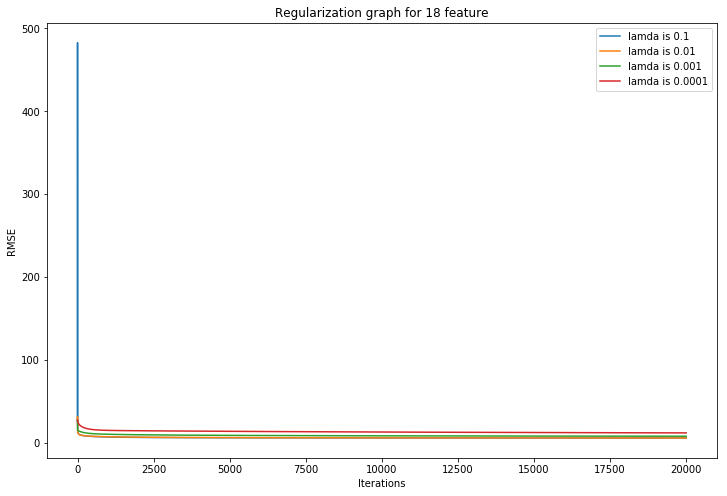

In [56]:
# 1 feature 9 hour
opt_cost = 100
opt_w = np.ones((train_x_18_9.shape[1]))
plt.figure(figsize=(12,8))
plt.title('Regularization graph for 18 feature')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
for i in [0.1,0.01,0.001,0.0001]:
    w,cost = Adagrad(train_x_18_9,train_y_9,i,20000)
#     if(cost[-1] < opt_cost):
#         opt_cost = cost[-1]
#         opt_w = w
#     print(cost[-1])
    x = [i for i in range(20000)]
    y = np.array(cost)**0.5
    plt.plot(x,y,label=f'lamda is {i}')
plt.legend(loc = 'upper right')
plt.show()
plt.savefig('regularization_18.png')

In [13]:
pre = np.dot(test_x_18_9,opt_w)
output_result('output_rp18.csv',pre)

     id      value
0  id_0   5.246913
1  id_1  17.055572
2  id_2  24.077396
3  id_3   7.815355
4  id_4  26.901141


In [8]:
def rmse(pre,test):
    tmp = 0
    for i,p in enumerate(pre):
        tmp += (p-test[i])**2
    return (tmp/pre.shape[0])**0.5